In [1]:
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:01:01
🔁 Restarting kernel...


In [1]:
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj
    on_colab = True
    #clear_output()  # clear the excessive installation outputs
    print("Dependencies successfully installed!")
except ModuleNotFoundError:
    on_colab = False

✨🍰✨ Everything looks OK!
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mdtraj


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge
    blosc-1.21.1               |       hd32f23e_0         955 KB  conda-forge
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  conda-forge
    certifi-2022.6.15          |   py37h89c1867_0         155 KB  conda-forge
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forge
    cudatoolkit-11.1.1         |      ha002fc5_10        1.20 GB  conda-forge
    hdf5-1.10.4                |nompi_h3c11f04_1106         5.3 MB  conda-forge
    libblas-3.9.0              |       8_openblas          11 KB  conda-forge
    libcblas-3.9.0             |       8_openblas          11 KB  co

In [3]:
!conda install -q -y -c conda-forge mdtraj
!conda --version


/bin/bash: conda: command not found
/bin/bash: conda: command not found


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


/content/gdrive/MyDrive/Colab Notebooks/Molecular_Simulations/GPU_for_pf/data/proteins/stripped_T0955.pdb
[log] num lines: 54
[log] n_blocks: 50
[log] n_atoms: 164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[log] min energy: 2623.82
[log] min energy pdb saved!
[log] run time (ms): 1344
[[5311.96 5311.96 5311.96 ... 3066.53 3066.53 3066.53]
 [5311.96 5311.96 5311.96 ... 2890.67 2890.67 2890.67]
 [5311.96 5311.96 5311.96 ... 2778.25 2778.25 2778.25]
 ...
 [5311.96 5311.96 5311.96 ... 2939.96 2939.96 2939.96]
 [5311.96 5311.96 5311.96 ... 3026.8  3026.8  3026.8 ]
 [5311.96 5311.96 5311.96 ... 3048.5  3048.5  3048.5 ]]
(50, 82001)


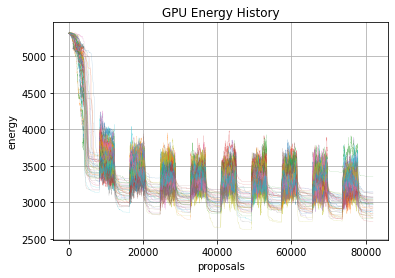

In [26]:
# read the state from results.txt and save a pdb of the protein. Use the same protein as the gpu kernel's pf_data.csv.  


import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# user parameters ###########################################################################################
protein_name = 'T0955'
plot_type = "exact"                 # exact or spread
n_runs = 1

two_block_plot = False      # set to True to plot spread of two runs(w/ varying blocks) on same plot. ONLY works for n_runs == 2.
two_time_plot = False        # set to True to plot spread of two runs on same plot with x_axis as time. ONLY works for n_runs == 2.
# time_one_ms = 2305
# time_two_ms = 13397
#initial_state_pdb_filename = r'proteins/T0955/T0955_unfolded.pdb' # desktop
initial_state_pdb_filename = r'/content/gdrive/MyDrive/Colab Notebooks/Molecular_Simulations/GPU_for_pf/data/proteins/stripped_{}.pdb'.format(protein_name) # google colab
results_folder = r"/content/gdrive/MyDrive/Colab Notebooks/Molecular_Simulations/GPU_for_pf/results" # google colab

#############################################################################################################

print(initial_state_pdb_filename)
# each row is an e_history; plots each line overlapping. 
def plot_exact(all_e_history):
    for i, line in enumerate(all_e_history):
        plt.plot(line, label=f'block {i}', alpha=0.5, linewidth=0.2)
    plt.xlabel('proposals')
    plt.ylabel('energy')
    # plt.legend()
    plt.title('GPU Energy History')
    plt.grid(visible=True)
    plt.savefig(results_folder + "/exact.pdf")
    plt.show()

# each row is an e_history. Plots mean+-std. 
def plot_spread(all_e_history):
    one_std = np.std(all_e_history, axis=0)
    means = np.mean(all_e_history, axis=0)
    minus_std = np.mean(all_e_history, axis=0) - one_std
    plus_std = np.mean(all_e_history, axis=0) + one_std
    mins = np.amin(all_e_history, axis=0)
    maxs = np.amax(all_e_history, axis=0)
    x = np.arange(0,len(all_e_history[0]))

    fig, ax = plt.subplots()
    ax.plot(x, mins, x, maxs, color='blue')
    ax.fill_between(x, mins, maxs, alpha=0.2)
    ax.plot(x, means, color='red')
    #ax.plot(x, mins, color='black')
    plt.xlabel('proposals')
    plt.ylabel('energy')
    plt.grid(visible=True)
    plt.savefig(results_folder+'/spread.pdf')  
    plt.show()

def plot_spread_two_block(all_e_history, n_blocks_in_run2):
    n_blocks_in_run1 = all_e_history.shape[0] - n_blocks_in_run2
    all_e_history1 = all_e_history[0:n_blocks_in_run1, :]
    all_e_history2 = all_e_history[n_blocks_in_run1+1:, :]
    
    one_std1 = np.std(all_e_history1, axis=0)
    means1 = np.mean(all_e_history1, axis=0)
    minus_std1 = np.mean(all_e_history1, axis=0) - one_std1
    plus_std1 = np.mean(all_e_history1, axis=0) + one_std1
    mins1 = np.amin(all_e_history1, axis=0)
    maxs1 = np.amax(all_e_history1, axis=0)
    one_std2 = np.std(all_e_history2, axis=0)
    means2 = np.mean(all_e_history2, axis=0)
    minus_std2 = np.mean(all_e_history2, axis=0) - one_std2
    plus_std2 = np.mean(all_e_history2, axis=0) + one_std2
    mins2 = np.amin(all_e_history2, axis=0)
    maxs2 = np.amax(all_e_history2, axis=0)
    x = np.arange(0,len(all_e_history[0]))

    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(10,10)) #3.14961 = 80 mm
    ax.plot(x, mins1, x, maxs1, color='red')
    ax.fill_between(x, mins1, maxs1, alpha=0.1, color ='red')
    ax.plot(x, means1, '--', color='red')

    ax.plot(x, mins2, x, maxs2, color='blue')
    ax.fill_between(x, mins2, maxs2, alpha=0.2, color='blue')
    ax.plot(x, means2, '--', color='blue')
    custom_lines = [Line2D([0], [0], linestyle='solid',color='red'),
                    Line2D([0], [0], linestyle='solid', color='blue')]
    ax.legend(custom_lines, [f'{n_blocks_in_run1} blocks min-mean-max', f'{n_blocks_in_run2} blocks min-mean-max'])
    plt.xlabel('proposals')
    plt.ylabel('energy')
    plt.title('Protein Structure Prediction')
    plt.grid(visible=True)
    plt.savefig(results_folder+'/spread.pdf')  
    plt.show()

def plot_spread_two_block_over_time(all_e_history, n_blocks_in_run2, time_one_ms, time_two_ms):
    n_blocks_in_run1 = all_e_history.shape[0] - n_blocks_in_run2
    all_e_history1 = all_e_history[0:n_blocks_in_run1, :]
    all_e_history2 = all_e_history[n_blocks_in_run1+1:, :]
    
    one_std1 = np.std(all_e_history1, axis=0)
    means1 = np.mean(all_e_history1, axis=0)
    minus_std1 = np.mean(all_e_history1, axis=0) - one_std1
    plus_std1 = np.mean(all_e_history1, axis=0) + one_std1
    mins1 = np.amin(all_e_history1, axis=0)
    maxs1 = np.amax(all_e_history1, axis=0)
    peak_min1 = np.amin(mins1)
    one_std2 = np.std(all_e_history2, axis=0)
    means2 = np.mean(all_e_history2, axis=0)
    minus_std2 = np.mean(all_e_history2, axis=0) - one_std2
    plus_std2 = np.mean(all_e_history2, axis=0) + one_std2
    mins2 = np.amin(all_e_history2, axis=0)
    maxs2 = np.amax(all_e_history2, axis=0)
    peak_min2 = np.amin(mins2)

    print(f"mins1; {peak_min1}, mins2: {peak_min2}")
    x1 = np.linspace(0,time_one_ms, num=len(all_e_history[0]))
    x2 = np.linspace(0,time_two_ms, num=len(all_e_history[0]))
    if time_one_ms > time_two_ms:
        x = x1
    else: 
        x = x2

    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(3.14961,3.14961))
    ax.plot(x1, mins1, x1, maxs1, color='blue')
    ax.fill_between(x1, mins1, maxs1, alpha=0.2, color='blue')
    ax.plot(x1, means1, color='red')
    ax.plot(x, [peak_min1]*len(x), color='black')

    ax.plot(x2, mins2,'--', x2, maxs2, '--', color='blue')
    ax.fill_between(x2, mins2, maxs2, alpha=0.2, color='blue')
    ax.plot(x2, means2, '--', color='red')
    ax.plot(x, [peak_min2]*len(x), color='black')

    custom_lines = [Line2D([0], [0], color='black', linestyle= 'solid'),
                    Line2D([0], [0], linestyle='dashed', color='black'),
                    Line2D([0], [0], linestyle='dashdot', color='red'),
                    Line2D([0], [0], linestyle='dashdot', color='blue')]
    ax.legend(custom_lines, [f'{n_blocks_in_run1} blocks', f'{n_blocks_in_run2} blocks', 'mean', 'min-max'])
    plt.xlabel('time (ms)')
    plt.ylabel('energy')
    plt.title('Protein structure prediction over 82000 proposals')
    plt.grid(visible=True)
    plt.savefig(results_folder+'/spread.pdf')  
    plt.show()



# read topology data for protein
default_traj = md.load(initial_state_pdb_filename)
topology = default_traj.topology
all_e_history = []
for run in range(n_runs):
    
    # read the state from results.txt
    fname = results_folder + "/" + "results" + str(run) + ".txt"
    with open(fname) as file: 
        lines = file.read().splitlines()
    print(f'[log] num lines: {len(lines)}')

    # line 0
    n_blocks = int(lines[0])
    print(f'[log] n_blocks: {n_blocks}')

    # line 1
    state = lines[1].split(',')
    n_atoms = int(len(state)/3)
    state2d = np.zeros((n_atoms, 3))
    for atom in range(0, n_atoms*3, 3): 
        ind = int(atom/3)
        for ii in range(3):
            state2d[ind][ii] = float(state[atom+ii])
    state2d = np.nan_to_num(state2d)
    minenergy_traj = md.Trajectory(state2d, topology)
    print(f"[log] n_atoms: {n_atoms}")

    # line 2->2+n_blocks
    for b in range(n_blocks):
        e_history = lines[2+b].split(',')
        for i, ele in enumerate(e_history):
            e_history[i] = float(ele)
        e_history = np.array(e_history)
        if all_e_history == []:
            all_e_history = e_history
        else:
            all_e_history = np.vstack([all_e_history, e_history])
    
    # line 2+n_blocks
    energy = lines[n_blocks+2].split(',')[0]
    print(f"[log] min energy: {energy}")
    minenergy_traj.save(results_folder + '/min_energy_' + str(energy) + '.pdb')
    print("[log] min energy pdb saved!")
    
    # line 2+n_blocks+1
    time_ms = lines[n_blocks+3].split(',')[0]
    print(f"[log] run time (ms): {time_ms}")
    


if len(all_e_history.shape) == 1:
    all_e_history = np.expand_dims(all_e_history, axis=0)

print(all_e_history)
print(all_e_history.shape)

if plot_type == "exact":
    plot_exact(all_e_history)

elif not two_block_plot and not two_time_plot and plot_type == "spread":
    plot_spread(all_e_history)
elif two_block_plot and plot_type == "spread" and n_runs==2:
    plot_spread_two_block(all_e_history, n_blocks)
elif two_time_plot and plot_type == "spread" and n_runs==2:
    plot_spread_two_block_over_time(all_e_history, n_blocks, time_one_ms, time_two_ms)
else: 
    print("[Error] Something went wrong with the setup of the problem.")


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b